reference 
1. brooks
2. http://whiskyanalysis.com/index.php/methodology-introduction/methodology-flavour-comparison/
3. https://www.mathstat.strath.ac.uk/outreach/nessie/nessie_whisky.html- 

### Introduction

philosophical discussion based upon philosophy and whisky. 

does this method make sense? comments from readers?

now that we have a rating. we can potentially calculate the best value by taking into account price as well. divide by price?

can also use this method for evaluating a variety of "goods", like a husband or wife, an apartment, etcetc

assuming all these characteristics are positives. if a negative, then 0 and 5 scale should be reversed. how data is compiled? the rating associated with each distillery is for their flagship release. doesn't capture the full range of products released by a distillery. read about rating at 2 above

define what it is for an instance of something to be "best". hegel - whisky and philosophy

two characteristics: 1) complex (count), 2) balance (mean/std). how to combine these two to get an unique ranking?

use experts to describe characteristics of whisky but not determine rank. we are interested in a rating/ranking scheme, not a classification one.

have characteristics concerning smell and taste, missing others? like visual ones?

enjoying/preferring a scotch is not the same as it being the best/ideal

this rating scheme has a big negative. it doesn't require any tasting on my part.

Batches vary. barrels vary. single malts are subject to variation. taste is not objective due to preference and tasting ability. though the ideal sctoch can be defined objectively? at least what "best" or "ideal" means

so now that we have determined the best or ideal scotches that doesn't mean you will like them. that's preference based. and tasting ability.

what are the properties of the rating system? mean? count? std?

assuming intensity of flavor is a positive, but variance of intensity is not.

### Theory

### Calculations

#### Import Data

In [23]:
%matplotlib inline
import pandas as pd
import numpy as np

In [24]:
file_name = 'whiskies_w_coords.csv'
top_scotches_to_map = 5

In [25]:
data = pd.read_csv(file_name)

#### Process Data

In [26]:
to_rename = {
    'whiskies.Latitude':'FinalLat',
    'whiskies.Longitude':'FinalLong'
}
data = data.rename(columns=to_rename)
data.head()

,Unnamed: 0,RowID,Distillery,Body,Sweetness,Smoky,Medicinal,Tobacco,Honey,Spicy,Winey,Nutty,Malty,Fruity,Floral,Postcode,Latitude,Longitude,FinalLat,FinalLong
0,1,1,Aberfeldy,2,2,2,0,0,2,1,2,2,2,2,2,\tPH15 2EB,286580,749680,-3.850199,56.625191
1,2,2,Aberlour,3,3,1,0,0,4,3,2,2,3,3,2,\tAB38 9PJ,326340,842570,-3.229644,57.467395
2,3,3,AnCnoc,1,3,2,0,0,2,0,0,2,2,3,2,\tAB5 5LI,352960,839320,-2.785295,57.441751
3,4,4,Ardbeg,4,1,4,4,0,0,2,0,1,2,1,0,\tPA42 7EB,141560,646220,-6.108503,55.640607
4,5,5,Ardmore,2,2,2,0,0,1,1,1,2,3,1,1,\tAB54 4NH,355350,829140,-2.743629,57.350557


Break data set into two pieces: one piece that contains the tasting notes, and one piece that contains the location information

In [27]:
data = data.set_index('Distillery')
data = data.loc[:,'Body':]

In [30]:
flavors = data.loc[:, 'Body':'Floral']
location = data.loc[:, 'FinalLat':]

#### Calculate individual scores and ranking

first calculate the number of characteristics with non-zero intensity rating

In [31]:
flavors_count = flavors != 0
ratings = pd.DataFrame()
ratings['NonZeroFlavors'] = flavors_count.sum(axis=1)

next calculate average rating per whisky and standard deviation of scores. higher mean is better. lower standard deviation is better since whisky is more balanced and no characteristic dominates its flavor profile.

In [32]:
ratings['Mean'] = flavors.mean(axis=1)
ratings['Std'] = flavors.std(axis=1)
ratings['Score'] = ratings['Mean']/ratings['Std']

In [33]:
ratings.head()

,NonZeroFlavors,Mean,Std,Score
Distillery,,,,
Aberfeldy,10,1.583333,0.792961,1.996734
Aberlour,10,2.166667,1.267304,1.709665
AnCnoc,8,1.416667,1.164500,1.216545
Ardbeg,8,1.583333,1.621354,0.976550
Ardmore,10,1.333333,0.887625,1.502135


In [34]:
by_score_count = ratings.sort_values(by=['NonZeroFlavors', 'Score'], ascending=False)
by_score = ratings.sort_values(by='Score', ascending=False)
by_mean = ratings.sort_values(by='Mean', ascending=False)
by_std = ratings.sort_values(by='Std', ascending=False)

show by_mean, by_score, then by_score_count?

In [35]:
by_score_count.head(10)

,NonZeroFlavors,Mean,Std,Score
Distillery,,,,
Bruichladdich,11,1.583333,0.668558,2.368281
OldPulteney,11,1.500000,0.674200,2.224860
Scapa,11,1.500000,0.674200,2.224860
Bowmore,11,1.500000,0.797724,1.880350
OldFettercairn,11,1.500000,0.797724,1.880350
Dalmore,11,1.666667,0.887625,1.877669
RoyalBrackla,11,1.666667,0.887625,1.877669
Craigallechie,11,1.750000,0.965307,1.812894
Highland Park,11,1.416667,0.792961,1.786552


not surprised the extreme scotches are ranked top by std since severaly dominated by a few flavor characteristics 

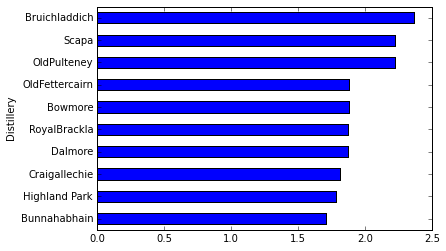

In [36]:
by_score_count['Score'].head(10).sort_values().plot(kind='barh')

top ranked scotches mapped. are the top scotches confined to a specific geographic region?

In [20]:
map_data = by_score_count.head(top_scotches_to_map).merge(location, how='left', left_index=True, right_index=True)

In [22]:
map_data.reset_index().loc[:,['FinalLat','FinalLong','Distillery']].to_csv('top_whiskies.csv')

if ranking is not indicative of highest quality scotches, why might that be? essential component of flavor or something else missing? flavor classification is not? advertisment, quality is responsible for notierity of certain brands. our definition of "best" differs from how most judge whisky. for example, the smoky islay scotches won't be at the top of the list due to their extreme flavor profile, though interestingly the top ranked scotch is from islay, just not one of the smoky guys. notice this rating system is all about balance.